# ニューラルネットワークを使った手書き文字認識：初級編
昨今世間を騒がせているバズワードとしてのAIの一つの正体である「**ディープラーニング(深層学習)**」。  
今回はその基本となる考え方である「**ニューラルネットワーク**」について、実装して行きます。  
題材は画像認識の分野でのHello worldと言われている「**MNIST**」という手書き数字認識問題です。

## モジュールのインポート

配列形式のデータを扱うために[numpy](http://www.numpy.org/ "Numpy公式Document")、  
データのプロットのために[matplotlib](https://matplotlib.org/ "matplotlib公式Document")、  
モデルの性能評価のために[scikit-learn(sklearn)](https://scikit-learn.org/stable/ "Scikit-learn公式Document")を、  
それぞれインポートします。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, accuracy_score

メインのニューラルネットワークモデルの構築のために、  
[keras](https://keras.io/ja/ "Keras公式Document")から必要なものをインポートします。

In [2]:
# MNISTデータセット
from keras.datasets import mnist
# シーケンシャルモデル
from keras.models import Sequential
# それぞれ平坦化層、全結合層、活性化層
from keras.layers import Flatten, Dense, Activation
# numpyアレイの便利な取り扱い
from keras.utils import np_utils
# 過学習の検出
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## データセット
MNISTデータセットをダウンロードし、その中身を確認します。  
訓練データが60000サンプル、評価データが10000サンプルあり、  
画像は28x28pixelの256階調のグレースケールです。

In [3]:
# MNISTのダウンロード
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
# 訓練データ、評価データの入力データ、教師データの構造
print('x_train :', x_train.shape)
print('y_train :', y_train.shape)
print('x_test  :', x_test.shape)
print('y_test  :', y_test.shape)

x_train : (60000, 28, 28)
y_train : (60000,)
x_test  : (10000, 28, 28)
y_test  : (10000,)


In [5]:
def show_samples(images):
    """
    複数の画像データを表示する関数
    * 入力
        samples (numpy.ndarray) : 入力画像たち
    * 出力：
        None
    """
    num_samples = images.shape[0]
    # サンプル画像の枚数分のプロット領域を作り、位置を調整
    fig, axs = plt.subplots(1,num_samples, figsize=(18,2))
    fig.subplots_adjust(wspace=.05)
    axs = axs.ravel()
    for i in range(num_samples):
        # サンプル画像をプロット領域に描画
        axs[i].imshow(images[i], cmap='gray')
        # 縦横の軸を消去
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    # プロットを表示
    plt.show()

教師データと訓練データの一例を表示します。

[7 2 1 0 4 1 4 9 5 9]


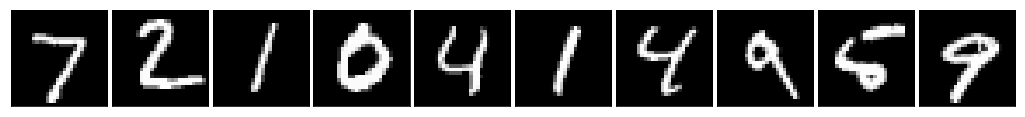

In [6]:
# はじめの10サンプル分を選択
indexes = np.arange(0,10)
# 以下のように、直接番号で指定することも可能
# indexes = [0,1,2,3,4,5,6,7,8,9]
# 選んだサンプルの教師ラベルを表示
print(y_test[indexes])
# 選んだサンプルの入力データを表示
show_samples(x_test[indexes])

## 前処理
教師データと入力データの形式を変換します。  
教師データは1hotベクトル変換、入力データは正規化を行います。

In [7]:
# np_udilsから教師ラベルを1ホットベクトルに変換
y_train_1hot = np_utils.to_categorical(y_train)
y_test_1hot = np_utils.to_categorical(y_test)
# 変換後のデータの構造を確認
print('y_train_1hot :', y_train_1hot.shape)
print('y_test_1hot :', y_test_1hot.shape)

y_train_1hot : (60000, 10)
y_test_1hot : (10000, 10)


In [8]:
# 1ホットベクトル形式を確認
index = 0
print('origin', y_train[index])
print('normed', y_train_1hot[index])

origin 5
normed [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [9]:
# 入力画像の正規化
# x_train_normed = (x_train / 255.).astype(np.float32)
# x_test_normed = (x_test / 255.).astype(np.float32)
x_train_normed = ((x_train - 127.5) / 127.5).astype(np.float32)
x_test_normed = ((x_test - 127.5) / 127.5).astype(np.float32)

In [10]:
# 正規化されたデータを確認
print('\tmin\tmax')
print('origin\t{0}\t{1}'.format(x_train.min(), x_train.max()))
print('normed\t{0}\t{1}'.format(x_train_normed.min(), x_train_normed.max()))

	min	max
origin	0	255
normed	-1.0	1.0


## 設計
データを学習させるニューラルネットワークの構造と、学習方法を設計します。

In [11]:
# 入力データの形式と教師データのラベル数を取得
input_shape = x_train_normed.shape[1:]
num_labels =  y_train_1hot.shape[-1]
# 隠れ層のノード数を設定
num_hidden = 1024

# シーケンシャルモデルのインスタンス化
model = Sequential()
# 入力データへの平坦化層を追加
model.add(Flatten(input_shape =input_shape))
# 全結合層を追加
model.add(Dense(num_hidden))
model.add(Dense(num_labels))
# 全結合層へのソフトマックス活性化層を追加
model.add(Activation('softmax'))

In [12]:
# モデルの概要を表示
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              803840    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10250     
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 814,090
Trainable params: 814,090
Non-trainable params: 0
_________________________________________________________________


In [13]:
# モデルの学習アルゴリズムの設定
model.compile(
    # 学習方法に「SGD」を設定
    optimizer='sgd',
    # 損失関数に「CrossEntropy」を設定
    loss='categorical_crossentropy',
    # 学習過程で認識精度を表示
    metrics=['accuracy'])

## 学習
モデルにデータを与えて学習を行います。

In [14]:
history = model.fit(
    # 訓練データを指定
    x_train_normed, y_train_1hot, 
    # ミニバッチ処理のバッチサイズを設定
    batch_size=32,
    # 学習エポック数を設定
    epochs=10,
    # 評価データを指定
    validation_split=0.2,
    # 過学習が始まったら学習を終了
    callbacks=[EarlyStopping()]
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 7s 155us/step - loss: 0.4494 - acc: 0.8644 - val_loss: 0.3290 - val_acc: 0.9067
Epoch 2/10
48000/48000 [==============================] - 7s 147us/step - loss: 0.3315 - acc: 0.9042 - val_loss: 0.2946 - val_acc: 0.9187
Epoch 3/10
48000/48000 [==============================] - 7s 150us/step - loss: 0.3132 - acc: 0.9100 - val_loss: 0.3416 - val_acc: 0.8982


## 評価
学習済みモデルの性能評価を行います。

In [15]:
# 学習済みモデルに評価データを入力して予測
predictions = model.predict_classes(x_test_normed)

In [16]:
# 精度の表示
accuracy_score(predictions, y_test)

0.8953

In [17]:
# 混同行列の表示
confusion_matrix(predictions, y_test)

array([[ 935,    0,    7,    5,    1,    6,   12,    3,   10,    8],
       [   0, 1101,    9,    0,    2,    2,    3,   12,    7,    5],
       [   1,    3,  906,   16,    2,    1,    3,   19,    5,    1],
       [   1,    2,   12,  808,    2,    6,    0,    6,   24,    6],
       [   0,    0,    6,    0,  867,    3,    7,    4,    6,   10],
       [  34,   11,   24,  148,   21,  854,   36,   11,  143,   33],
       [   7,    4,   20,    2,   19,   11,  895,    0,   14,    1],
       [   1,    1,   10,    8,    2,    1,    1,  911,    4,   11],
       [   1,   12,   27,   11,    3,    6,    1,    1,  744,    2],
       [   0,    1,   11,   12,   63,    2,    0,   61,   17,  932]])

predictions : [7 2 1 0 4 1 4 9 6 9]
answers     : [7 2 1 0 4 1 4 9 5 9]


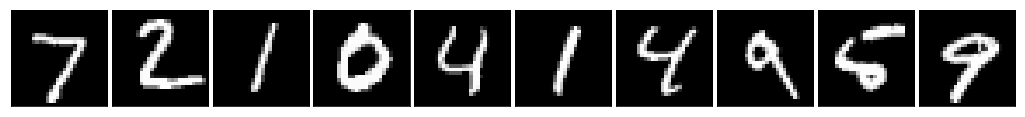

In [18]:
# 評価データから10個のサンプルを取得
indexes = np.arange(0,10)
# samples = x_test_normed[indexes]
# 選んだサンプルデータをモデルに入力し、識別結果を取得
# predicted_samples = model.predict_classes(samples)
predicted_samples = predictions[indexes]
# 正解データと比較
answers = y_test[indexes]
print('predictions :', predicted_samples)
print('answers     :', answers)
show_samples(x_test[indexes])

In [19]:
# 作成したモデルを保存
model.save('../model/simple_model.h5')